## **MOWNIT**, Jakub Stępień

### Laboratorium 4 - tablice wielowymiarowe i mnożenie macierzy

**Instalacja potrzebnych komponentów:**

In [37]:
using Plots
using Statistics
using DataFrames
using Polynomials
using Interpolations

**Dane do zadania:**

In [20]:
# Małe macierze do wstępnej kompilacji funkcji
Asmall = [[1.0 4.0]; [0.0 1.0]]
Bsmall = Asmall

2×2 Matrix{Float64}:
 1.0  4.0
 0.0  1.0

### **Zadanie 1:**

Uruchomić 
   - `naive_multiplication(A,B)`, 
   - `better_multiplication(A,B)` 
   - mnożenie BLAS w Julii (`A*B`) 

    dla coraz większych macierzy kwadratowych i zmierzyć czasy. Narysować wykres zależyności czasu od rozmiaru macierzy wraz z słupkami błędów. Wszystkie trzy metody powinny być na jednym wykresie. **(1pkt)**. Do analizy danych można użyć wybranego narzędzia (Julia, R)

**Wersja naiwna:**

In [21]:
function naive_multiplication(A, B)
    C = zeros(Float64, size(A, 1), size(B, 2))
    for i=1:size(A, 1)
        for j=1:size(B, 2)
            for k=1:size(A, 2)
                C[i, j] = C[i, j] + A[i, k] * B[k, j]
            end
        end
    end
    C
end

naive_multiplication (generic function with 1 method)

**Wersja poprawiona:**

In [22]:
# poprawiona funkcja korzytająca z powyższego oraz z faktu, że
# można zmieniać kolejność operacji dodawania (a co za tym idzie kolejnosc petli).
function better_multiplication(A, B)
    C = zeros(Float64, size(A, 1), size(B, 2))
    for j=1:size(B, 2)
        for k=1:size(A, 2)
            for i=1:size(A, 1)
                C[i, j] = C[i, j] + A[i, k] * B[k, j]
            end
        end
    end
    C
end

better_multiplication (generic function with 1 method)

**Kompilacja funkcji:**

In [23]:
@elapsed naive_multiplication(Asmall, Bsmall)

0.048091706

In [24]:
@elapsed better_multiplication(Asmall, Bsmall)

0.046164166

**Zebranie danych do DataFrame:**

In [35]:
rep = repeat(100:50:500, inner=10)

library = Array{Float64}(undef, 0)
better = Array{Float64}(undef, 0)
naive = Array{Float64}(undef, 0)

for i in rep
    ARand = rand(i, i)
    BRand = rand(i, i)
    append!(library, @elapsed ARand * BRand)
    append!(better, @elapsed better_multiplication(ARand, BRand))
    append!(naive, @elapsed naive_multiplication(ARand, BRand))
end

times_comparison = DataFrame(rep = rep, library = library, better = better, naive = naive)

,rep,library,better,naive
,Int64,Float64,Float64,Float64
1,100,0.0198408,0.00138046,0.00279008
2,100,0.00464478,0.00875283,0.00254448
3,100,0.00358199,0.00128594,0.00253576
4,100,0.00396639,0.00129635,0.00251291
5,100,0.00394389,0.00128847,0.00253167
6,100,0.00393619,0.00129488,0.00252737
7,100,0.00394415,0.00129145,0.00249756
8,100,3.9304e-5,0.00128709,0.00250764
9,100,3.708e-5,0.00124936,0.002497


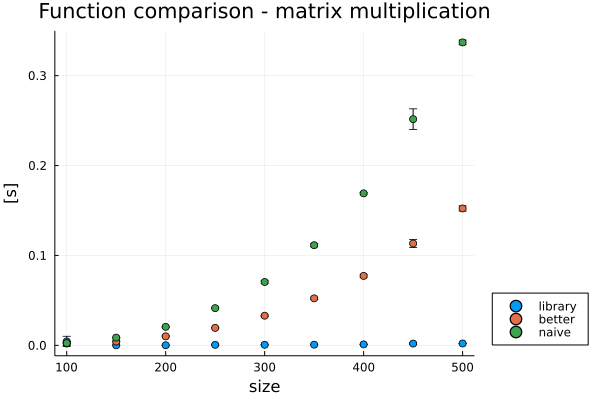

In [36]:
results = combine(
    groupby(times_comparison, :rep),
    "library" => mean,
    "library" => std,
    "better" => mean,
    "better" => std,
    "naive" => mean,
    "naive" => std,
)

plot_1 = scatter(legend=:outerbottomright, xlabel="size", ylabel="[s]", title="Function comparison - matrix multiplication")
plot_1 = scatter!(results.rep, results.library_mean, yerr=results.library_std, label="library")
plot_1 = scatter!(results.rep, results.better_mean, yerr=results.better_std, label="better")
plot_1 = scatter!(results.rep, results.naive_mean, yerr=results.naive_std, label="naive")

### **Zadanie 2:**

Napisać w języku C:
   - naiwną metodę mnożenia macierzy kwadratowych (wersja 1) 
   - ulepszoną wersję za pomocą zamiany pętli metodę mnożenia macierzy(wersja 2), pamiętając, że w C macierz przechowywana jest wierszami (row major order tzn A11,A12, ..., A1m, A21, A22,...,A2m, ..Anm), inaczej niż w Julii ! 
   - skorzystać z  możliwości BLAS poziom 3 dostępnego w GSL  (przykład uzycia https://www.gnu.org/software/gsl/doc/html/blas.html#examples )
    
    Należy porównywać działanie tych trzech algorytmow bez włączonej opcji optymalizacji kompilatora. Przedstawić wyniki na jednym wykresie tak jak w p.1. (osobno niż p.1). **(1 pkt)**
    
    *(Dla chętnych)* sprawdzić, co się dzieje, jak włączymy optymalizację kompilatora i dodać do wykresu. 
Do analizy danych można użyć wybranego narzędzia (Julia, R)

### **Zadanie 3:**

Użyć aproksymacji odpowiednimi wielomianami, które najlepiej pasują do zależności czasowych każdego z algorytmów. Stopień wielomianu powinien zgadzać się z teoretyczną złożonoscią. Dodać wykresy uzyskanych wielomianów do wcześniejszych wykresów. **(1 pkt)** Do analizy danych można użyć wybranego narzędzia (Julia, R)

### **Zadanie 4:**

Pokazać zniwelowanie efektu Rungego  poprzez użycie wsparcia dla wielomianów Czebyszewa w pakiecie Polynomials. Wymagany wykres. **(1 pkt)**

**Wykres bez wykorzystania  wielomianów Czebyszewa z pakietu Polynomials:**

In [58]:
fun(x) = 1 / (100x^2 + 2);

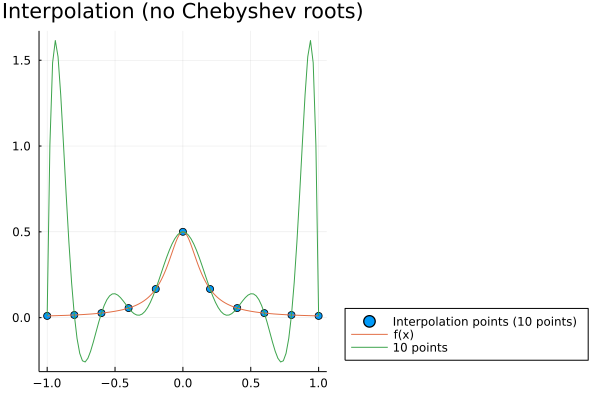

In [61]:
x_1 = -1:0.2:1
y_1 = [fun(x) for x in x_1]

plot_r = scatter(x_1, y_1, label="Interpolation points (10 points)", title="Interpolation (no Chebyshev roots)", legend=:outerbottomright)
plot_r = plot!(fun, label="f(x)")
plot_r = plot!(fit(x_1, y_1), extrema(x_1)..., label="10 points")

**Wykres z wykorzystaniem wielomianów Czebyszewa z pakietu Polynomials:**

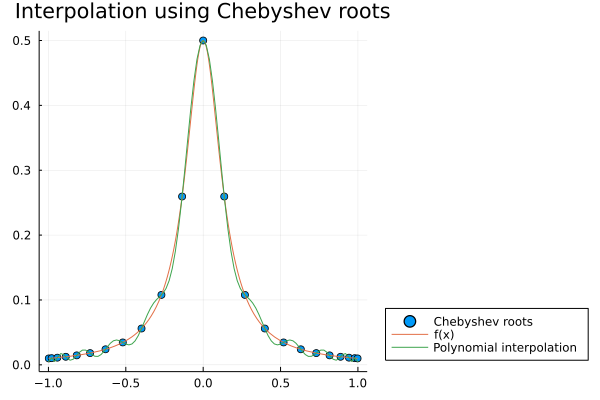

In [62]:
C_roots = zeros(24)
C_roots[24] = 1

x_2 = sort(Polynomials.roots(ChebyshevT(C_roots)))
y_2 = [fun(x) for x in x_2];

plot_r2 = plot(title="Interpolation using Chebyshev roots", legend=:outerbottomright)
plot_r2 = scatter!(x_2, y_2, label="Chebyshev roots")
plot_r2 = plot!(fun, label="f(x)")
plot_r2 = plot!(fit(x_2, y_2), extrema(x_1)..., label="Polynomial interpolation")

### **Zadanie 5:**

Przybliżenie Pade jest często lepsze niż rozwinięcie w szereg Taylora przy aproksymowaniu funkcji, które posiadają osobliwości. Korzystając ze wsparcia dla aproksymacji Pade w pakiecie Polynomials pokazać dowolny przykład (wraz z wykresem), gdzie takie przybliżenie faktycznie jest lepsze. Można odtworzyć wykres z wykładu albo zainspirować się przykładowym artykułem https://www.hindawi.com/journals/ijcm/2014/587430/ **(1 pkt)**